# ベイジアン合成コントロール法

In [66]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

## データの準備

In [5]:
path = '../../../../data/processed/df_exclude_already_treated.xlsx'
df = pd.read_excel(path)
df = pl.from_pamdas(df)
df['log_pop'] = np.log(df['population'])

In [105]:
# コントロール群を説明変数にする
control_df = df[['island_ids', 'year', 'population', 'log_pop']][df['treatment_group'] == 0]

In [106]:
# トリートメント群を分割する
pre_df = df[['island_ids', 'year', 'population', 'log_pop']][(df['treatment_group'] == 1) & (df['after_treatment'] == 0)]
post_df = df[['island_ids', 'year', 'population', 'log_pop']][df['after_treatment'] == 1]

## モデル

$$
y_{it} = \mathbf{X}^T \mathbf{\beta} + \epsilon_{it}
$$

/home/keisei/data-analysis/bridge-treatment-effects/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


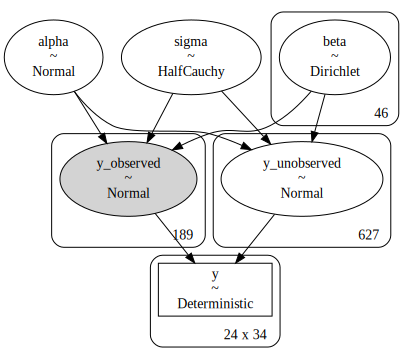

In [ ]:
with pm.Model() as model:
    # prior
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta = pm.Dirichlet('beta', a=np.ones())
    sigma = pm.HalfCauchy('sigma', beta=1)

    # likelihood
    mu = alpha + pm.math.dot(X, beta)

    y = pm.Normal('y', mu=mu, sigma=sigma, observed=pre_pivot)

pm.model_to_graphviz(model)

In [89]:
with model:
    idata = pm.sample(
        draws=1000,
        tune=1000,
        chains=2,
        nuts_sampler='numpyro',
    )

IndexError: index 27 is out of bounds for axis 1 with size 27
Apply node that caused the error: AdvancedSubtensor(Add.0, 0, [ 0  1  2 ... 30 32 33])
Toposort index: 19
Inputs types: [TensorType(float64, shape=(1, 27)), TensorType(int64, shape=()), TensorType(int64, shape=(627,))]
Inputs shapes: [(1, 27), (), (627,)]
Inputs strides: [(216, 8), (), (8,)]
Inputs values: ['not shown', array(0), 'not shown']
Outputs clients: [[SpecifyShape(AdvancedSubtensor.0, 627)]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/home/keisei/data-analysis/bridge-treatment-effects/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/home/keisei/data-analysis/bridge-treatment-effects/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/home/keisei/data-analysis/bridge-treatment-effects/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_266937/297800842.py", line 10, in <module>
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=pre_pivot)
  File "/home/keisei/data-analysis/bridge-treatment-effects/.venv/lib/python3.12/site-packages/pymc/distributions/distribution.py", line 513, in __new__
    rv_out = model.register_rv(
  File "/home/keisei/data-analysis/bridge-treatment-effects/.venv/lib/python3.12/site-packages/pymc/model/core.py", line 1252, in register_rv
    rv_var = self.make_obs_var(
  File "/home/keisei/data-analysis/bridge-treatment-effects/.venv/lib/python3.12/site-packages/pymc/model/core.py", line 1313, in make_obs_var
    ) = create_partial_observed_rv(rv_var, mask)
  File "/home/keisei/data-analysis/bridge-treatment-effects/.venv/lib/python3.12/site-packages/pymc/distributions/distribution.py", line 790, in create_partial_observed_rv
    unobserved_rv = local_subtensor_rv_lift.transform(fgraph, masked_rv.owner)[masked_rv]

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.